In [1]:
import autograd.numpy as np
from autograd import grad
import pandas as pd
import sys
%matplotlib inline

#### Loading the dataset

In [2]:
d = np.load("/Users/nipun/Downloads/data-2013-2017-missing.npy").item()

#### Finding homes occuring across both years

In [3]:
np.intersect1d(list(d[2016].keys()), list(d[2015].keys())).size

214

In [4]:
np.intersect1d(list(d[2017].keys()), list(d[2016].keys())).size

153

I would be choosing 2015 and 2016 as the successive years

In [5]:
use_homes = np.intersect1d(list(d[2016].keys()), list(d[2015].keys()))

In [6]:
use_homes

array([  26,   59,   77,   86,   93,   94,  101,  114,  187,  434,  484,
        499,  503,  545,  624,  744,  781,  871,  946,  974, 1086, 1103,
       1169, 1192, 1202, 1283, 1403, 1415, 1463, 1500, 1507, 1589, 1617,
       1632, 1642, 1697, 1700, 1718, 1790, 1800, 1953, 2018, 2094, 2129,
       2156, 2171, 2199, 2233, 2365, 2378, 2472, 2532, 2557, 2575, 2638,
       2755, 2787, 2814, 2818, 2829, 2859, 2945, 2953, 2965, 3009, 3039,
       3044, 3134, 3268, 3310, 3367, 3392, 3456, 3482, 3500, 3527, 3538,
       3577, 3649, 3778, 3829, 3831, 3849, 3916, 3918, 3935, 3967, 4031,
       4154, 4213, 4220, 4297, 4298, 4336, 4342, 4352, 4357, 4373, 4375,
       4473, 4514, 4641, 4767, 4874, 4946, 4957, 4998, 5026, 5060, 5129,
       5218, 5275, 5317, 5357, 5403, 5545, 5568, 5677, 5718, 5785, 5809,
       5814, 5874, 5889, 5921, 5949, 5959, 5972, 6061, 6063, 6121, 6139,
       6165, 6348, 6412, 6423, 6460, 6498, 6691, 6692, 6730, 6990, 7016,
       7030, 7361, 7390, 7429, 7504, 7536, 7560, 76

In [7]:
APPLIANCE_ORDER = ['use','air1','dishwasher1','furnace1','kitchenapp1','microwave1','refrigerator1']

### Creating the tensor data

In [8]:
t = np.empty((len(use_homes), len(APPLIANCE_ORDER), 2*12))

In [9]:
t[:] = np.NaN

In [10]:
for i, home in enumerate(use_homes):
    for j, appliance in enumerate(APPLIANCE_ORDER):
        try:
            t[i, j, :12] = d[2016][home][appliance].values
            t[i, j, 12:] = d[2017][home][appliance].values
        except:
            pass

In [11]:
t.shape

(214, 7, 24)

### STF routine

In [12]:
def factorise(tensor, r, random_seed=0, num_iter=400, eps=1e-8, lr=1):
    np.random.seed(random_seed)
    args_num = [1, 2, 3]

    def cost(tensor, home, appliance,  month):
        pred = np.einsum('Hr, Ar, Tr ->HAT', home, appliance, month)
        mask = ~np.isnan(tensor)
        error = (pred - tensor)[mask].flatten()
        return np.sqrt((error ** 2).mean())

    mg = grad(cost, argnum=args_num)
    sizes = [(x, r) for x in tensor.shape]
    home = np.random.rand(*sizes[0])
    appliance = np.random.rand(*sizes[1])
    month = np.random.rand(*sizes[2])

    sum_home = np.zeros_like(home)
    sum_appliance = np.zeros_like(appliance)
    sum_month = np.zeros_like(month)

    # GD procedure
    for i in range(num_iter):
        del_home, del_appliance, del_month = mg(tensor, home, appliance, month)

        sum_home += eps + np.square(del_home)
        lr_home = np.divide(lr, np.sqrt(sum_home))
        home -= lr_home * del_home

        sum_appliance += eps + np.square(del_appliance)
        lr_appliance = np.divide(lr, np.sqrt(sum_appliance))
        appliance -= lr_appliance * del_appliance

        sum_month += eps + np.square(del_month)
        lr_month = np.divide(lr, np.sqrt(sum_month))
        month -= lr_month * del_month

        
        # Projection to non-negative space
        home[home < 0] = 1e-8
        appliance[appliance < 0] = 1e-8
        month[month < 0] = 1e-8

        if i % 500 == 0:
            #print(cost(tensor, home, appliance, month), i)
            sys.stdout.flush()

    return home, appliance, month

#### Creating the different subsets if data

In [13]:
# Test is last 44 homes
test_set = t[170:].copy()
# In test set, we don't know the appliance data
test_set[:, 1:, :] = np.NaN
# Train + Pool is the remaining set
train_pool_set = t[:170].copy()
# Initial train set is 10 homes
train_set = t[:10].copy()
# Initial pool set is 10-170 homes
pool_set = t[10:170].copy()
pool_homes = use_homes[10:170]
# Train + Test set (useful for factorisation)
train_test_set = np.vstack([train_set, test_set])

### Creating the set of (home, appliance) pairs for each month that can contain data and thus can be used for acquiring labels

In [14]:
p_m_h = {}
for month in range(12, 24):
    p_m_h[month] = []
    for home in pool_homes:
        for i, appliance in enumerate(APPLIANCE_ORDER[1:]):
            pool_home_index  = np.searchsorted(use_homes, home)
            if np.isfinite(t[pool_home_index, i+1, month]):
                p_m_h[month].append((home, appliance))

In [15]:
p_m_h[13][:5]

[(499, 'air1'),
 (499, 'furnace1'),
 (499, 'kitchenapp1'),
 (499, 'refrigerator1'),
 (503, 'air1')]

#### Randomly adding 5 homes every month from Pool

In [16]:
pool_use = np.empty((0, 7, 24))
pool_set_iter = p_m_h.copy()
pred_df_random = {}
pool_remove_ix = {}
pool_remove = {}
gt_df = {}

for cur_iteration, month in enumerate(range(12, 24)):
    
    # Randomly choose `n` to remove from pool and put in training set
    pool_remove_ix[cur_iteration] = np.random.choice(range(len(pool_set_iter[month])), size=5)
    pool_remove[month] = [pool_set_iter[month][x] for x in pool_remove_ix[cur_iteration]]
    
    # Remove these from future months pool too
    for month_f in range(month+1, 24):
        for x in pool_remove[month]:
            if x in pool_set_iter[month_f]:
                pool_set_iter[month_f].remove(x)
    
    
    # Getting data from `t` to create the pool_use_set
    pool_remove_homes = [x[0] for x in pool_remove[month]]
    pool_remove_homes_ix = np.searchsorted(use_homes, pool_remove_homes)
    
    cur_pool = t[pool_remove_homes_ix, :, :].copy()
    # All past data is unknown
    cur_pool[:, 1:, :month] = np.NaN
    
    # All future data for all appliances except the chosen one is known
    cur_pool[:, 1:, month:] = np.NaN
    for q, h in enumerate(pool_remove_homes_ix):
        appliance_num = APPLIANCE_ORDER.index(pool_remove[month][q][1])
        cur_pool[q, appliance_num, month:] = t[h, appliance_num, month:]
    
    pool_use = np.concatenate([pool_use, cur_pool])
    
    pool_train_test = np.concatenate([pool_use, train_test_set[:, :, :] ])

    h, a, m =factorise(pool_train_test[:, :, :month], 3)
    print(cur_iteration, month, len(pool_train_test), pool_remove[month])
    
    pred = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)
    pred_df_random[month] = pred[len(train_set)+len(pool_use):,1:, month-1:month].reshape(-1, len(APPLIANCE_ORDER)-1)
    gt_df[month] = t[170:][:, 1:, month-1:month].reshape(len(test_set), len(APPLIANCE_ORDER)-1)

0 12 59 [(2953, 'air1'), (3482, 'refrigerator1'), (6460, 'dishwasher1'), (7940, 'refrigerator1'), (7850, 'kitchenapp1')]
1 13 64 [(2199, 'furnace1'), (3500, 'air1'), (1632, 'kitchenapp1'), (3649, 'air1'), (503, 'dishwasher1')]
2 14 69 [(7361, 'microwave1'), (8059, 'refrigerator1'), (7951, 'microwave1'), (1507, 'furnace1'), (7788, 'dishwasher1')]
3 15 74 [(6691, 'furnace1'), (5545, 'air1'), (1632, 'refrigerator1'), (1632, 'air1'), (5959, 'air1')]
4 16 79 [(2859, 'refrigerator1'), (3778, 'furnace1'), (4998, 'kitchenapp1'), (8079, 'refrigerator1'), (5545, 'kitchenapp1')]
5 17 84 [(8079, 'furnace1'), (7627, 'furnace1'), (8079, 'air1'), (5949, 'air1'), (5921, 'refrigerator1')]
6 18 89 [(5545, 'microwave1'), (5317, 'microwave1'), (3778, 'air1'), (3482, 'dishwasher1'), (2638, 'air1')]
7 19 94 [(5026, 'air1'), (1202, 'furnace1'), (2532, 'microwave1'), (2171, 'microwave1'), (6139, 'air1')]
8 20 99 [(5317, 'refrigerator1'), (503, 'air1'), (5874, 'furnace1'), (6165, 'dishwasher1'), (2171, 'refrig

### Active learning

In [17]:
pool_use = np.empty((0, 7, 24))
gt_df = {}
pred_df_active = {}
pool_remove_active = {}
pool_set_active = {}
all_seen = []

for cur_iteration, month in enumerate(range(12, 24)):
    
    # Get all the homes from the currently available pool

    pred_pool = {}
    psc = pool_set.copy()
    psc[:, 1:, :] = np.NaN
    month_contri = (pd.DataFrame(train_set[:, :, month]).mean()/pd.DataFrame(train_set[:, :, month]).mean()[0]).drop(0).to_dict()
    # Starting with current data and finding the variance amongst different #Latent factors
    for r in range(2, 8):
        print(month, r)
        pool_train = np.concatenate([psc, train_set[:, :, :] ])
        h, a, m =factorise(pool_train[:, :, :month], r)
        pred_pool[r] = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)[:len(pool_set)]
        
    # Finding the top-most `n` highly variance homes
    # measure = std/contri
    temp = []
    for appliance_num, appliance in enumerate(APPLIANCE_ORDER[1:]):
        y = pd.DataFrame({r:pd.Series(pred_pool[r][:, appliance_num+1, -1])for r in range(2, 8)}).std(axis=1)/month_contri[appliance_num+1]
        y.index = [(x, appliance) for x in pool_homes]
        temp.append(y)
        
    pool_remove_active[month] = pd.concat(temp).sort_values(ascending=False).drop(all_seen).head(10).index.tolist() 
    
    all_seen.extend(pool_remove_active[month])
    all_seen = list(set(all_seen))
    
    # Getting data from `t` to create the pool_use_set
    pool_remove_homes_active = [x[0] for x in pool_remove_active[month]]
    pool_remove_homes_active_ix = np.searchsorted(use_homes, pool_remove_homes_active)
    
    cur_pool = t[pool_remove_homes_active_ix, :, :].copy()
    # All past data is unknown
    cur_pool[:, 1:, :month] = np.NaN
    
    # All future data for all appliances except the chosen one is known
    cur_pool[:, 1:, month:] = np.NaN
    for q, h in enumerate(pool_remove_homes_ix):
        appliance_num = APPLIANCE_ORDER.index(pool_remove[month][q][1])
        cur_pool[q, appliance_num, month:] = t[h, appliance_num, month:]
    
    pool_use = np.concatenate([pool_use, cur_pool])
    
    pool_train_test = np.concatenate([pool_use, train_test_set[:, :, :] ])

    h, a, m =factorise(pool_train_test[:, :, :month], 3)
    print(cur_iteration, month, len(pool_train_test), pool_remove_active[month])
    
    pred = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)
    pred_df_active[month] = pred[len(train_set)+len(pool_use):,1:, month-1:month].reshape(-1, len(APPLIANCE_ORDER)-1)
    gt_df[month] = t[170:][:, 1:, month-1:month].reshape(len(test_set), len(APPLIANCE_ORDER)-1)

12 2
12 3
12 4
12 5
12 6
12 7
0 12 64 [(5357, 'microwave1'), (4336, 'air1'), (4336, 'microwave1'), (4336, 'kitchenapp1'), (1700, 'microwave1'), (3918, 'air1'), (6691, 'microwave1'), (5357, 'air1'), (2365, 'furnace1'), (1507, 'microwave1')]
13 2
13 3
13 4
13 5
13 6
13 7
1 13 74 [(3916, 'air1'), (4154, 'air1'), (7719, 'air1'), (5357, 'kitchenapp1'), (6691, 'air1'), (4375, 'kitchenapp1'), (4154, 'microwave1'), (1507, 'air1'), (2365, 'air1'), (4375, 'microwave1')]
14 2
14 3
14 4
14 5
14 6
14 7
2 14 84 [(5357, 'furnace1'), (4375, 'furnace1'), (7016, 'air1'), (4957, 'furnace1'), (7016, 'furnace1'), (5972, 'furnace1'), (7719, 'furnace1'), (6460, 'furnace1'), (6691, 'furnace1'), (7627, 'furnace1')]
15 2
15 3
15 4
15 5
15 6
15 7
3 15 94 [(3918, 'furnace1'), (2378, 'furnace1'), (2018, 'furnace1'), (1507, 'furnace1'), (545, 'furnace1'), (3500, 'furnace1'), (2472, 'furnace1'), (7719, 'refrigerator1'), (3039, 'furnace1'), (5809, 'furnace1')]
16 2
16 3
16 4
16 5
16 6
16 7
4 16 104 [(1700, 'kitchenap

In [18]:
random_error = {}
active_error = {}
for month in range(12, 24):
    random_error[month] = (pd.DataFrame(pred_df_random[month])-pd.DataFrame(gt_df[month])).abs().mean()
    active_error[month] = (pd.DataFrame(pred_df_active[month])-pd.DataFrame(gt_df[month])).abs().mean()

In [19]:
pd.DataFrame(random_error)

,12,13,14,15,16,17,18,19,20,21,22,23
0,192.946320,182.321965,95.172436,92.075232,111.293746,134.599378,237.087245,207.777029,210.506351,152.250212,106.358358,84.823408
1,14.232954,13.472206,15.423732,16.761749,14.720961,15.760640,17.656529,15.308081,13.578732,12.351281,11.219924,12.265989
2,98.111137,129.218063,67.215639,80.234360,89.555254,89.327881,113.315663,123.557990,125.570361,98.114912,63.637558,66.533036
3,12.735806,9.290671,10.714566,10.477167,11.329158,11.658033,11.485346,10.138663,9.198137,10.313277,9.942573,9.367254
4,12.931250,11.234057,7.517089,7.115828,8.728543,6.927375,8.165134,9.981826,7.348340,7.611376,6.664467,5.936085
5,38.758960,38.554075,38.869898,43.324292,41.744074,42.640576,50.864242,51.967292,45.657735,51.726461,45.705943,41.638361


In [20]:
pd.DataFrame(active_error)

,12,13,14,15,16,17,18,19,20,21,22,23
0,247.656087,122.638370,88.890796,88.764595,101.109912,137.625587,229.259371,339.355990,278.022511,221.829624,95.324368,56.779126
1,13.763496,12.764468,12.698550,13.725639,11.934047,11.492398,17.198627,17.757760,8.273332,5.396233,4.366339,6.070886
2,93.990758,130.158691,76.285236,86.935104,91.227044,78.368114,104.864368,142.089969,114.342235,93.866638,71.559766,66.433498
3,12.847597,10.259195,11.175042,10.029542,10.965339,12.205688,10.267806,10.565542,8.917808,8.006398,8.215192,7.307142
4,8.932115,9.480366,7.969368,7.260736,9.521968,5.861538,5.699413,6.757303,7.899674,9.812617,8.084825,8.348088
5,43.037263,40.239838,41.899114,45.148600,40.956129,42.103503,46.089626,45.274921,40.149663,39.932726,39.522369,43.394094


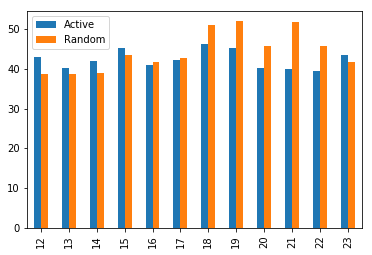

In [32]:
re = pd.DataFrame(random_error).iloc[5]
ac = pd.DataFrame(active_error).iloc[5]
pd.DataFrame({"Random":re, "Active":ac}).plot(kind='bar')